# Data period features

This notebook characterizes operational and environmental features for each water quality data period.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
from bayesian_wq_calibration.simulation import model_simulation
from bayesian_wq_calibration.plotting import plot_network
from bayesian_wq_calibration.constants import TIMESERIES_DIR
from bayesian_wq_calibration.data import get_sensor_stats, count_pressure_events

Load sensing data for selected data period.

In [136]:
data_period = 18 # 19 calibration events (as at 30 September 2024)

try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)

    print(f"Data period: {data_period}")
    print(f"Start datetime: {flow_df['datetime'].unique()[0]}")
    print(f"End datetime: {flow_df['datetime'].unique()[-1]}")
except:
    print(f"Data period {data_period} does not exist.")

Data period: 18
Start datetime: 2024-08-20 00:00:00
End datetime: 2024-08-27 23:45:00


### Sensor map

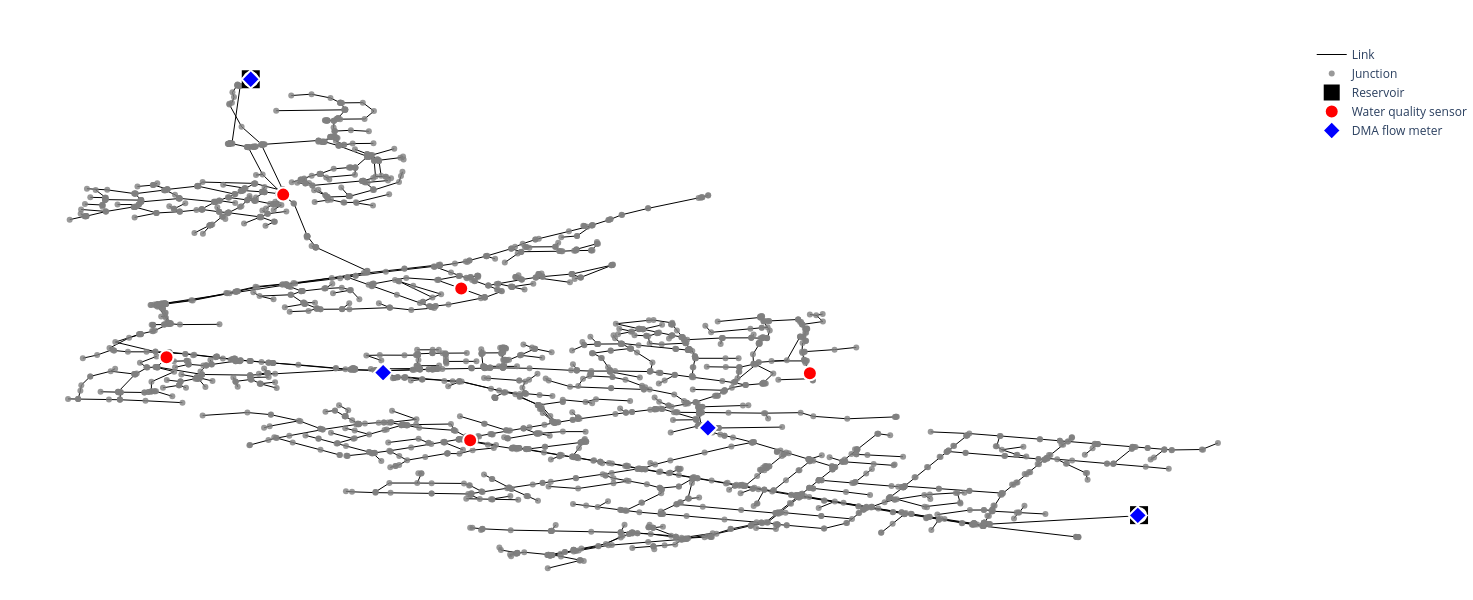

In [137]:
plot_network()

### Time series plotting
Chlorine data.

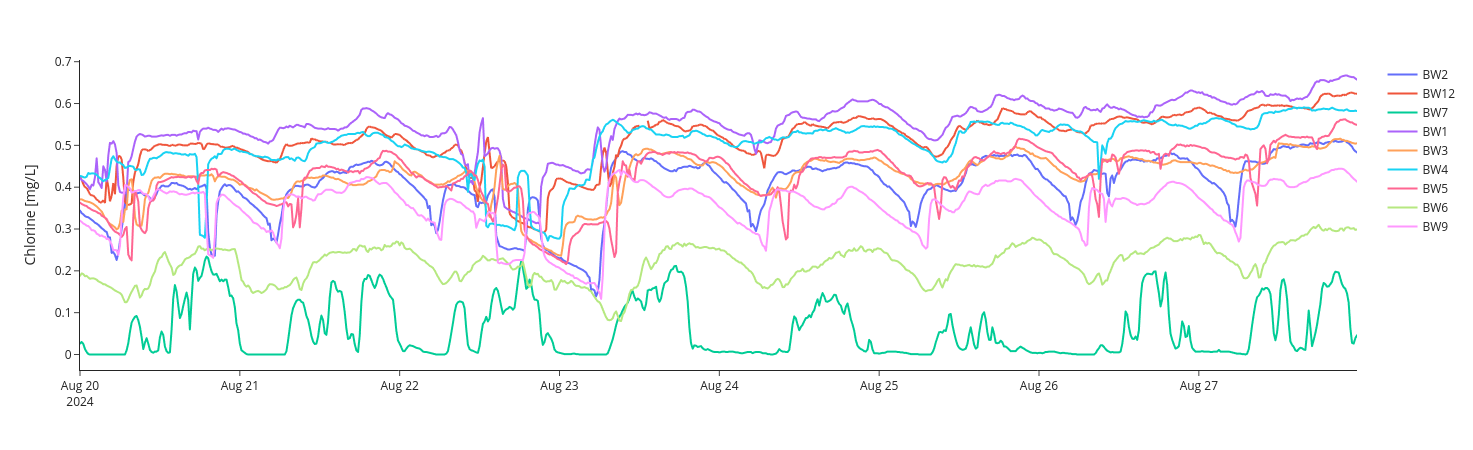

In [138]:
try:
    wq_bwfl_ids = wq_df['bwfl_id'].unique()
    plot_wq_df = wq_df[(wq_df['data_type'] == 'chlorine')]
    fig = px.line(
        plot_wq_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Chlorine [mg/L]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

Missing data summary.

In [139]:
summary_df = (plot_wq_df.groupby('bwfl_id')['mean'].agg(data_percentage=lambda x: int(x.notna().sum() / len(x) * 100)))
display(summary_df)

,data_percentage
bwfl_id,
BW1,100
BW12,99
BW2,100
BW3,100
BW4,100
BW5,100
BW6,100
BW7,100
BW9,100


Flow data.

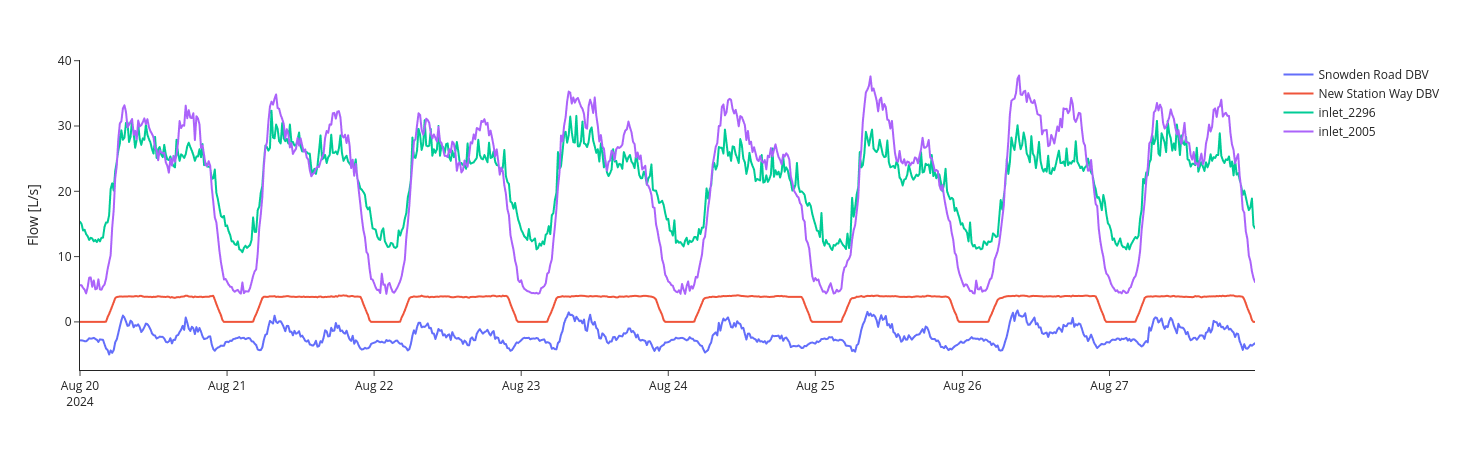

In [140]:
try:
    flow_bwfl_ids = ['inlet_2296', 'inlet_2005', 'Snowden Road DBV', 'New Station Way DBV']
    plot_flow_df = flow_df[flow_df['bwfl_id'].isin(flow_bwfl_ids)]
    fig = px.line(
        plot_flow_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Flow [L/s]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

### Hydraulic conditions

Flow comparison of data period v. entire dataset (2021-2024).  

In [108]:
# compute flow statistics
plot_flow_df = plot_flow_df.dropna(subset=['mean'])
flow_period_stats = plot_flow_df.groupby('bwfl_id')['mean'].describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])
print(f"Flow statistics for data period {data_period}.")
display(flow_period_stats)
flow_dataset_stats = get_sensor_stats('flow', flow_bwfl_ids)
print("Flow statistics for entire dataset.")
display(flow_dataset_stats)

Flow statistics for data period 12.


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
bwfl_id,,,,,,,,,,,,
New Station Way DBV,768.0,2.893065,1.627405,0.000320,0.001595,0.003422,1.634189,3.884447,3.943935,3.997591,4.092911,4.135994
Snowden Road DBV,768.0,0.452611,0.848255,-1.120516,-0.994961,-0.721844,-0.306472,0.476823,1.101425,1.597907,2.068154,2.249681
inlet_2005,768.0,25.229445,10.945300,5.766667,6.081556,7.144445,14.180556,29.683335,33.266666,36.777780,40.755558,41.977780
inlet_2296,768.0,22.183450,7.703297,9.111112,9.222222,10.111112,13.888889,25.444445,28.777779,30.333334,32.000000,33.444447


Flow statistics for entire dataset.


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
bwfl_id,,,,,,,,,,,,
New Station Way DBV,15001.0,2.636727,1.563789,-0.001273,-0.000074,0.001777,1.291219,3.439861,3.886272,3.965962,4.161019,4.401093
Snowden Road DBV,15001.0,0.032737,1.811904,-5.636987,-4.464525,-3.071937,-0.787046,0.511320,1.378140,1.905703,2.783175,3.443316
inlet_2005,15001.0,24.194245,10.816843,4.255556,4.500000,7.100000,13.111112,28.166668,32.433334,35.911114,40.588890,42.422222
inlet_2296,15001.0,21.683747,7.193723,8.444445,9.111112,10.555555,14.667000,23.666668,27.555555,29.888890,34.000000,36.777780


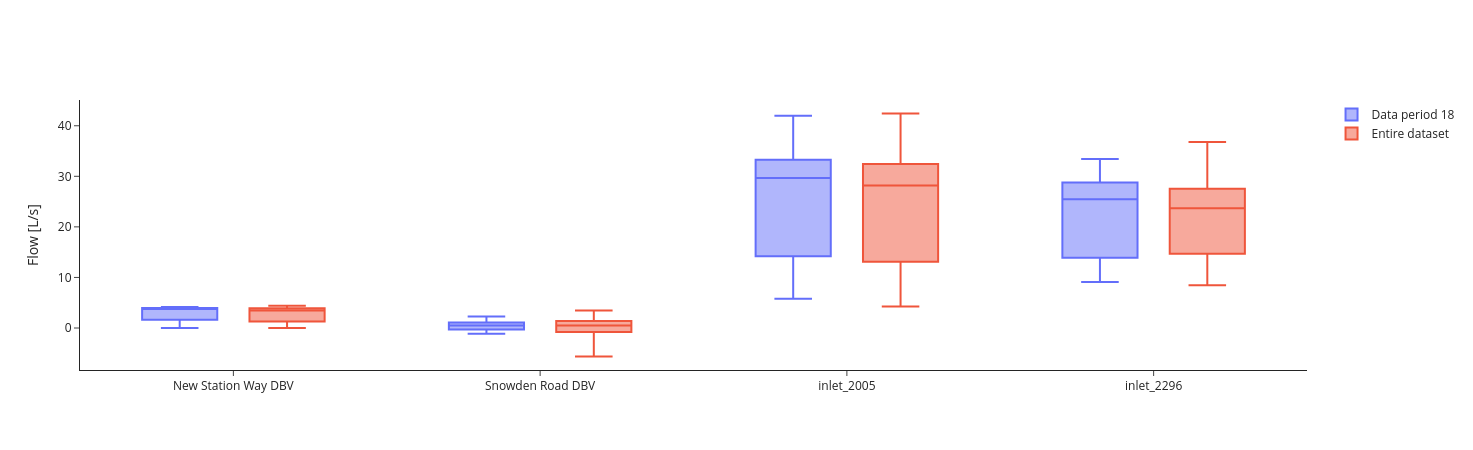

In [141]:
# boxplots
default_colors = plotly.colors.qualitative.Plotly
fig = go.Figure()

for i, bwfl_id in enumerate(flow_period_stats.index):
    stats = flow_period_stats.loc[bwfl_id]
    
    fig.add_trace(go.Box(
        x=[bwfl_id],
        lowerfence=[stats['min']],
        q1=[stats['25%']],
        median=[stats['50%']],
        q3=[stats['75%']],
        upperfence=[stats['max']],
        name=f'Data period {str(data_period).zfill(2)}',
        marker_color=default_colors[0],
        boxpoints=False,
        offsetgroup='flow_period_stats',
        showlegend=(i == 0)
    ))

for i, bwfl_id in enumerate(flow_period_stats.index):
    stats = flow_dataset_stats.loc[bwfl_id]
    
    fig.add_trace(go.Box(
        x=[bwfl_id],
        lowerfence=[stats['min']],
        q1=[stats['25%']],
        median=[stats['50%']],
        q3=[stats['75%']],
        upperfence=[stats['max']],
        name='Entire dataset',
        marker_color=default_colors[1],
        boxpoints=False,
        offsetgroup='flow_dataset_stats',
        showlegend=(i == 0)
    ))

fig.update_layout(
    yaxis_title='Flow [L/s]',
    xaxis_title='',
    xaxis=dict(
        tickmode='array',
        tickvals=flow_period_stats.index,
        ticktext=flow_period_stats.index
    ),
    legend_title_text='',
    template='simple_white',
    boxmode='group',
    height=450,
)

fig.show()

Count pressure events, which we define as a change in pressure of over $\Delta p=$ {threshold} m during a 15-minute time step.

In [142]:
threshold = 20
pressure_events = count_pressure_events(threshold=threshold)

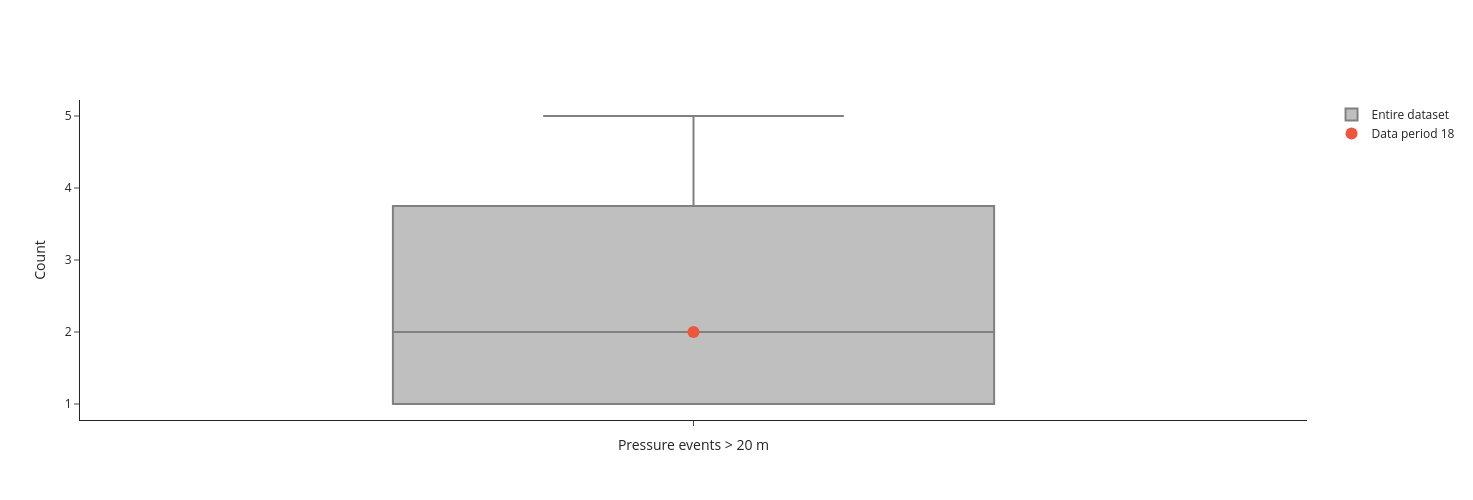

In [145]:
# plot comparison between data period and max event count for all data periods
fig = go.Figure()

fig.add_trace(go.Box(
    y=pressure_events,
    x=['Field Lab'] * len(pressure_events),
    name='Entire dataset',
    marker_color='grey',
    boxpoints=False
))

fig.add_trace(go.Scatter(
    y=[pressure_events[data_period-1]],
    x=['Field Lab'],
    marker_color=default_colors[1],
    marker=dict(color=default_colors[1], size=12),
    mode="markers",
    name=f'Data period {str(data_period).zfill(2)}',
))

fig.update_layout(
    yaxis_title='Count',
    xaxis_title=f"Pressure events > {threshold} m",
    template='simple_white',
    height=500,
    width=500,
    xaxis=dict(
        showticklabels=False
    ),
    yaxis=dict(
        range=[0, None],
        tickformat=',d',
        nticks=6
    )
)

fig.show()

### Water quality conditions

In [122]:
# results = model_simulation(flow_df, pressure_df, wq_df, sim_type='age', demand_resolution='wwmd', trace_node='node_2859')